In [16]:
y_true = []
with open('data/WebQA_label.txt', 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_true.append(int(pro[1]))

In [17]:
print(len(y_true), y_true[0:10])

448444 [0, 0, 0, 1, 0, 1, 1, 0, 0, 0]


In [18]:
scoreFile1 = 'predict/fasttext_custom.txt'
scoreFile2 = 'predict/fasttext.txt'
scoreFile3 = 'predict/cnn.txt'
scoreFile4 = 'predict/lstm.txt'
scoreFile5 = 'predict/attention.txt'

y_fasttext_custom = []
with open(scoreFile1, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_fasttext_custom.append(float(pro[1]))

y_fasttext = []
with open(scoreFile2, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_fasttext.append(float(pro[1]))

y_cnn = []
with open(scoreFile3, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_cnn.append(float(pro[1]))

y_lstm = []
with open(scoreFile4, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_lstm.append(float(pro[1]))

y_attention = []
with open(scoreFile5, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_attention.append(float(pro[1]))

In [19]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and y_fasttext_custom[i] < 0.5: num += 1
    if y_true[i] == 1 and y_fasttext_custom[i] >= 0.5: num += 1
print(num)
print(num / len(y_true))

307547
0.6858091534282987


In [20]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and y_fasttext[i] < 0.5: num += 1
    if y_true[i] == 1 and y_fasttext[i] >= 0.5: num += 1
print(num)
print(num / len(y_true))

307443
0.6855772404135188


In [24]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and y_cnn[i] < 0.5: num += 1
    if y_true[i] == 1 and y_cnn[i] >= 0.5: num += 1
print(num)
print(num / len(y_true))

312401
0.6966332474065882


In [25]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and y_lstm[i] < 0.5: num += 1
    if y_true[i] == 1 and y_lstm[i] >= 0.5: num += 1
print(num)
print(num / len(y_true))

314325
0.700923638180018


In [26]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and y_attention[i] < 0.5: num += 1
    if y_true[i] == 1 and y_attention[i] >= 0.5: num += 1
print(num)
print(num / len(y_true))

315603
0.7037734923424106


### 模型融合 - 投票

In [27]:
num = 0
for i in range(len(y_true)):
    t = 0
    f = 0
    if y_fasttext_custom[i] >= 0.5: t += 1
    else: f += 1
    if y_fasttext[i] >= 0.5: t += 1
    else: f += 1
    if y_cnn[i] >= 0.5: t += 1
    else: f += 1
    if y_lstm[i] >= 0.5: t += 1
    else: f += 1
    if y_attention[i] >= 0.5: t += 1
    else: f += 1
    if y_true[i] == 1 and t >= 3: num += 1
    if y_true[i] == 0 and f >= 3: num += 1
print(num)
print(num / len(y_true))

315177
0.7028235409549465


### 模型融合 - 平均 (1:1:1:1:1)

In [28]:
num = 0
for i in range(len(y_true)):
    pred = y_fasttext_custom[i] + y_fasttext[i] + y_cnn[i] + y_lstm[i] + y_attention[i]
    pred /= 5.0
    if y_true[i] == 0 and pred < 0.5: num += 1
    if y_true[i] == 1 and pred >= 0.5: num += 1
print(num)
print(num / len(y_true))

311728
0.6951325026090214


### 模型融合 - 权重 (1:1:2:2:2)

In [29]:
num = 0
for i in range(len(y_true)):
    pred = y_fasttext_custom[i] + y_fasttext[i] + 2 * y_cnn[i] + 2 * y_lstm[i] + 2 * y_attention[i]
    pred /= 10.0
    if y_true[i] == 0 and pred < 0.5: num += 1
    if y_true[i] == 1 and pred >= 0.5: num += 1
print(num)
print(num / len(y_true))

308942
0.6889199097323189


### MRR MAP TOP-1 评估
![alt text](img/mrr.jpg "title")
![alt text](img/map.jpg "title")
![alt text](img/acc.jpg "title")

In [12]:
import json

with open('data/WebQA.json', 'r') as f:
    data = json.load(f)

qIndex2aIndex = {} # 问题到答案的映射
aIndex2qIndex = {} # 答案到问题的映射
for qa in data:
    item_id = qa['item_id']
    qIndex2aIndex[item_id] = []
    for passage in qa['passages']:
        passage_id = passage['passage_id']
        qIndex2aIndex[item_id].append(passage_id)
        aIndex2qIndex[passage_id] = item_id

In [13]:
class Evaluator(object):
    qIndex2aIndex2aLabel = {} # 问题到答案到标签的映射
    qIndex2aIndex2aScore = {} # 问题到答案到分数的映射
    MRRList = []
    MAPList = []
    TOP_1List = []

    def __init__(self, qaPairFile, scoreFile):
        self.loadData(qaPairFile, scoreFile)

    def loadData(self, qaPairFile, scoreFile):
        qaPairLines = open(qaPairFile, 'r').readlines()
        scoreLines = open(scoreFile, 'r').readlines()
        assert len(qaPairLines) == len(scoreLines)
        
        for idx in range(len(qaPairLines)):
            qaLine = qaPairLines[idx].strip()
            scLine = scoreLines[idx].strip()
            qaLineArr = qaLine.split(',')
            scLineArr = scLine.split(',')
            
            assert qaLineArr[0] == scLineArr[0]
            assert len(qaLineArr) == 2
            assert len(scLineArr) == 2
            
            label = int(qaLineArr[1])
            score = float(scLineArr[1])
            aIndex = int(qaLineArr[0])
            qIndex = aIndex2qIndex[aIndex]
            
            if not qIndex in self.qIndex2aIndex2aScore:
                self.qIndex2aIndex2aScore[qIndex] = {}
                self.qIndex2aIndex2aLabel[qIndex] = {}
            self.qIndex2aIndex2aLabel[qIndex][aIndex] = label
            self.qIndex2aIndex2aScore[qIndex][aIndex] = score

    def calculate(self):
        # 对同一个问题分析答案
        for qIndex, index2label in self.qIndex2aIndex2aLabel.items():
            index2score = self.qIndex2aIndex2aScore[qIndex]
            rankedList = sorted(index2score.items(), key=lambda b: b[1], reverse=True) # 按照降序排序
            
            rankIndex = 0
            collectNum = 0
            collectList = []
            top = 0
            for info in rankedList:
                aIndex = info[0]
                label = index2label[aIndex]
                rankIndex += 1
                if label == 1:
                    if rankIndex == 1: top = 1 # TOP-1
                    collectNum += 1
                    p = float(collectNum) / rankIndex
                    collectList.append(p)
            self.MRRList.append(collectList[0])
            self.MAPList.append(float(sum(collectList)) / len(collectList))
            self.TOP_1List.append(top)

    def MRR(self):
        return float(sum(self.MRRList)) / len(self.MRRList)

    def MAP(self):
        return float(sum(self.MAPList)) / len(self.MAPList)

    def TOP_1(self):
        return float(sum(self.TOP_1List)) / len(self.TOP_1List)


def evaluate(qaPairFile, scoreFile):
    testor = Evaluator(qaPairFile, scoreFile)
    testor.calculate()
    print("MRR:%f \t MAP:%f \t TOP_1:%f\n" % (testor.MRR(), testor.MAP(), testor.TOP_1()))

In [30]:
qaPairFile = 'data/WebQA_label.txt'
scoreFile1 = 'predict/fasttext_custom.txt'
scoreFile2 = 'predict/fasttext.txt'
scoreFile3 = 'predict/cnn.txt'
scoreFile4 = 'predict/lstm.txt'
scoreFile5 = 'predict/attention.txt'

evaluate(qaPairFile, scoreFile1)
evaluate(qaPairFile, scoreFile2)
evaluate(qaPairFile, scoreFile3)
evaluate(qaPairFile, scoreFile4)
evaluate(qaPairFile, scoreFile5)

MRR:0.662440 	 MAP:0.563549 	 TOP_1:0.494302

MRR:0.630540 	 MAP:0.541773 	 TOP_1:0.455452

MRR:0.644062 	 MAP:0.550940 	 TOP_1:0.472327

MRR:0.656288 	 MAP:0.560791 	 TOP_1:0.487850

MRR:0.662439 	 MAP:0.565323 	 TOP_1:0.495279



## 线性回归 拟合

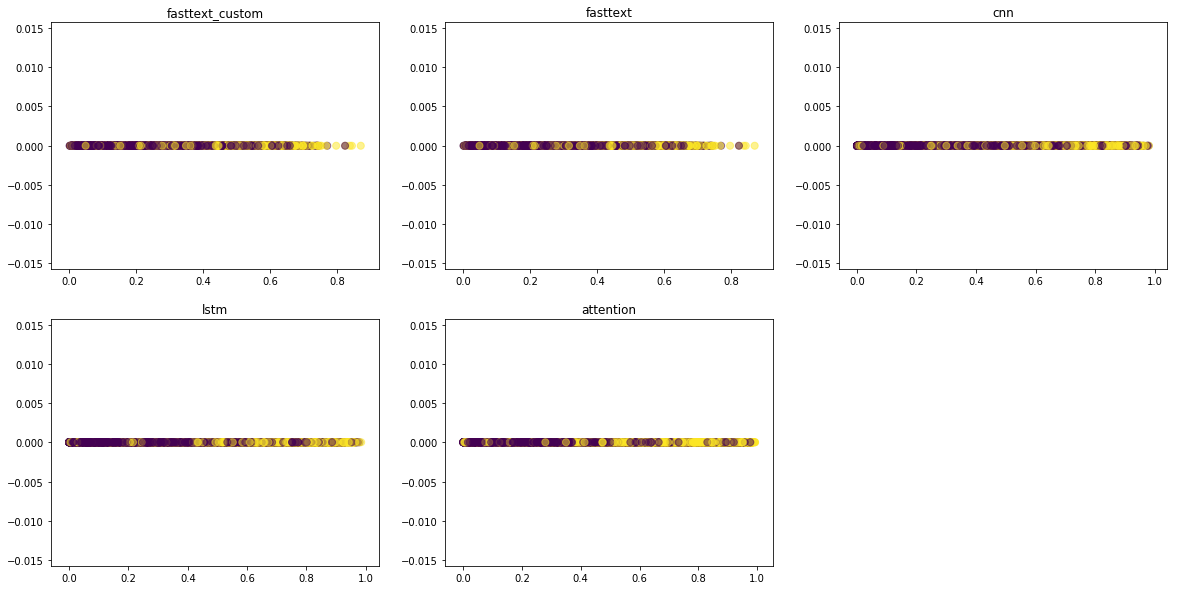

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

X1 = y_fasttext_custom
X2 = y_fasttext
X3 = y_cnn
X4 = y_lstm
X5 = y_attention
Y = [0] * len(y_true)
T = y_true

plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('fasttext_custom')
plt.scatter(X1, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 2)
plt.title('fasttext')
plt.scatter(X2, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 3)
plt.title('cnn')
plt.scatter(X3, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 4)
plt.title('lstm')
plt.scatter(X4, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 5)
plt.title('attention')
plt.scatter(X5, Y, s=50, c=T, alpha=.5)

plt.show()